In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime
import pandas as pd
import copy
import time

from scipy.ndimage import uniform_filter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
# define training folder path
training_folder_path = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA","training_data",'S2')
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")

# open all the training datasets, concat into single pandas df
df_1 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20190901T200911_021904_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_2 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20200909T194951_027252_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_3 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20210829T211521_032315_N03_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_4 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20220810T213541_037263_N04_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_5 = pd.read_csv(os.path.join(training_folder_path,'GS2A_20220918T202121_037820_N04_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_6 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20190822T210029_012853_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_7 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20200822T212529_018087_N02_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))
df_8 = pd.read_csv(os.path.join(training_folder_path,'GS2B_20210815T204019_023206_N03_training_dataset_1snow_2firn_3ice_4rock_5shadow_6water.csv'))

dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]

for i in range(len(dfs)):
    dfs[i]['image'] = i
df_all = pd.concat(dfs)

# rename bands
bands_orig = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
              'SO_B1', 'SO_B2', 'SO_B3', 'SO_B4', 'SO_B5', 'SO_B6', 'SO_B7', 'SO_B8', 'SO_B8A', 'SO_B9', 'SO_B11', 'SO_B12']
bands_new = ['coastal', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'vapor', 'swir1', 'swir2',
             'SO_coastal', 'SO_blue', 'SO_green', 'SO_red', 'SO_re1', 'SO_re2', 'SO_re3', 'SO_nir', 'SO_re4', 'SO_vapor', 'SO_swir1', 'SO_swir2']
bands_raw = ['coastal', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'vapor', 'swir1', 'swir2', 'ndwi', 'ndsi']

bands_dict = {bands_orig[i]:bands_new[i] for i in range(len(bands_orig))}
df_all = df_all.rename(columns=bands_dict)

# add ndsi, ndwi, dn
df_all['ndwi'] = (df_all['green']-df_all['nir'])/(df_all['green']+df_all['nir'])
df_all['SO_ndwi'] = (df_all['SO_green']-df_all['SO_nir'])/(df_all['SO_green']+df_all['SO_nir'])
df_all['ndsi'] = (df_all['green']-df_all['swir1'])/(df_all['green']+df_all['swir1'])
df_all['SO_ndsi'] = (df_all['SO_green']-df_all['SO_swir1'])/(df_all['SO_green']+df_all['SO_swir1'])

for i in bands_raw:
    df_all[f"DN_{i}"] = df_all[f"{i}"]/df_all[f"SO_{i}"]

# remove bad data
df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

print("All the data is loaded")

df_all.head()

All the data is loaded


,coastal,blue,green,red,re1,re2,re3,nir,re4,vapor,...,DN_re1,DN_re2,DN_re3,DN_nir,DN_re4,DN_vapor,DN_swir1,DN_swir2,DN_ndwi,DN_ndsi
0,8251,8466,8243,8510,8267,8037,7683,7008,7173,2292,...,0.879001,0.859388,0.825863,0.796726,0.785308,0.468903,0.213705,0.168295,12.256792,1.160852
1,8562,8580,8107,8175,8015,7696,7301,6741,6805,2502,...,0.879320,0.854636,0.831644,0.802596,0.790176,0.495838,0.172652,0.135787,5.611277,1.146127
2,7999,8020,7677,7965,7812,7516,7194,6608,6650,2391,...,0.871292,0.849938,0.825568,0.791946,0.782998,0.522623,0.173021,0.138021,4.683046,1.136459
3,7477,7548,7239,7517,7386,7208,6916,6333,6463,2278,...,0.881279,0.867911,0.856895,0.819806,0.823417,0.533115,0.706226,0.593692,2.061660,1.024818
4,7564,7630,7387,7722,7545,7343,7040,6491,6601,2310,...,0.870142,0.864696,0.852816,0.824045,0.815643,0.552499,0.655738,0.533448,1.821246,1.033019


In [3]:
#%%
# define predictor variable names and target variable name
predictors = [  'coastal', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'vapor', 'swir1', 'swir2', 'ndsi', 'ndwi',
                'SO_coastal', 'SO_blue', 'SO_green', 'SO_red', 'SO_re1', 'SO_re2', 'SO_re3', 'SO_nir', 'SO_re4', 'SO_vapor', 'SO_swir1', 'SO_swir2', 'SO_ndsi', 'SO_ndwi',
                'DN_coastal', 'DN_blue', 'DN_green', 'DN_red', 'DN_re1', 'DN_re2', 'DN_re3', 'DN_nir', 'DN_re4', 'DN_vapor', 'DN_swir1', 'DN_swir2', 'DN_ndsi', 'DN_ndwi',
              ]
              
target = 'type'

# select the data
X = df_all[predictors]
Y = df_all[target]
                 
# set class weights for the classifier
weights = {1:1, 2:1, 3:1, 4:0.5, 5:0.2, 6:0.2}

In [4]:
# run 8-fold cross validation to get the best model for each
all_models = {}
for i in df_all['image'].unique():
#     if i!=2: continue
    print(i)
    
    # separate test and train
    df_train = df_all[df_all['image']!=i]
    df_test = df_all[df_all['image']==i]
    
    # select the data
    X_train = df_train[predictors]
    Y_train = df_train[target]
    X_test = df_test[predictors]
    Y_test = df_test[target]
    
    # initiate and fit the classifier. model parameters were previously chosen from cross-validation search
    RFC = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_split=500, min_samples_leaf=100,
                                 class_weight=weights, max_features='sqrt', n_jobs=-1, oob_score=True, random_state = 336)
    RF_fit = RFC.fit(X_train, Y_train)
    
    # save the details of this model
    all_models[i]=RF_fit
print("Done")

0
1
2
3
4
5
6
7
Done


In [5]:
# get oob, accuracy, etc... for each
results_df = []
cms = []
importances = []

for i in df_all['image'].unique():
#     if i!=2: continue
#     print(i)
    
    model=all_models[i]
    
    # separate test and train
    df_train = df_all[df_all['image']!=i]
    df_test = df_all[df_all['image']==i]
    
    # select the data
    X_train = df_train[predictors]
    Y_train = df_train[target]
    X_test = df_test[predictors]
    Y_test = df_test[target]
    
    # get test prediction
    Y_pred = model.predict(X_test)
    
    oob = round(model.oob_score_, 4)
    accuracy = round(accuracy_score(Y_test, Y_pred), 4)
    precision = round(precision_score(Y_test, Y_pred, average='weighted'), 4)
    recall = round(recall_score(Y_test, Y_pred, average='weighted'), 4)
    f1 = round(f1_score(Y_test, Y_pred, average='weighted'), 4)
    
    # Create the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    cms.append(cm)
    
    # save importances
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    importances.append(feature_importances)
    
    # save scores
    outdic = {"OOB":oob, "Accuracy":accuracy, "Precision":precision, "Recall":recall, "F1":f1 }
    results_df.append(outdic)   
    

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
results_df = pd.DataFrame(results_df)
importances_df = pd.DataFrame(importances).T
avg_cm = np.array(cms).mean(axis=0)

In [7]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

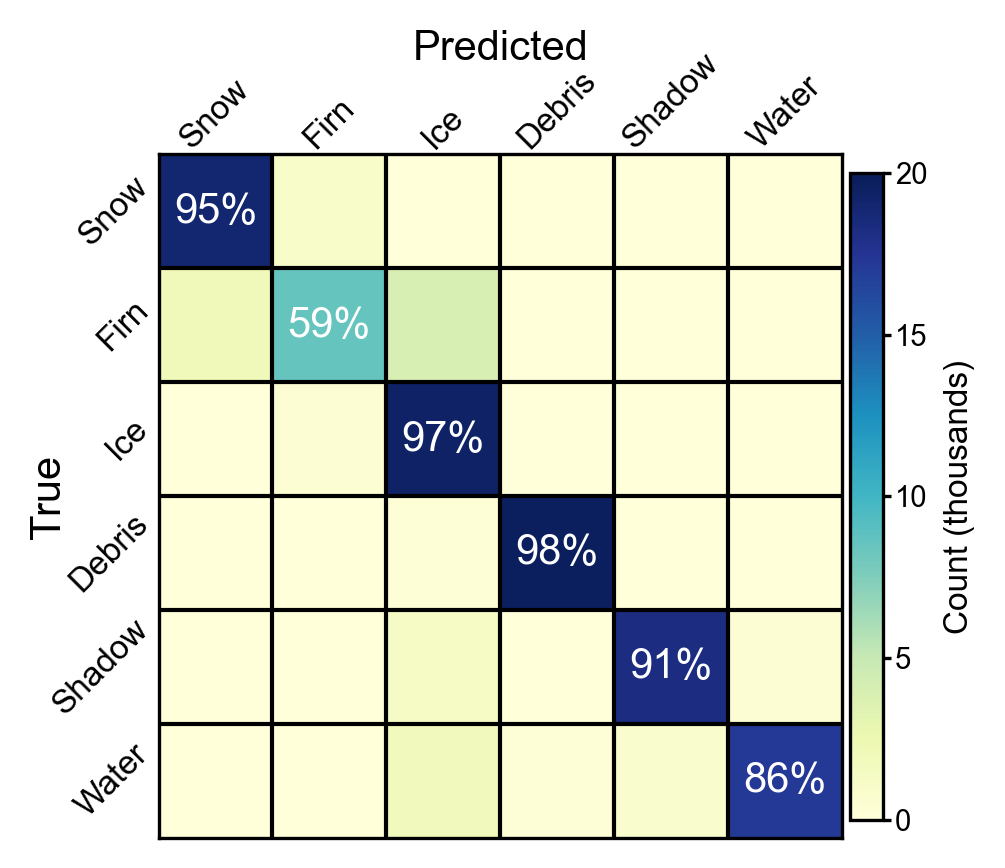

In [9]:
# figure showing comfusion matrix
fig,axs = plt.subplots(figsize=(3.5,4), dpi=300)

to_show = avg_cm
im = axs.imshow(to_show, vmin=0, vmax=20000, cmap="YlGnBu")

labels = ['Snow', 'Firn', 'Ice', 'Debris', 'Shadow', 'Water']

axs.set_xticks([0,1,2,3,4,5])
axs.set_xticklabels(labels, ha='center', size=8)
axs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, rotation=45, pad=0, length=0)

axs.set_yticks([0,1,2,3,4,5])
axs.set_yticklabels(labels, va='center', size=8)
axs.yaxis.set_tick_params(pad=1)

axs.set_ylabel("True", labelpad=-5)
axs.set_xlabel("Predicted", labelpad=-3)
axs.xaxis.set_label_position('top') 

# add label for accuracy of each class
for i in [0,1,2,3,4,5]:
    acc = round(to_show[i][i]/np.sum(to_show[i])*100)
    axs.text(i,i,f"{acc}%", horizontalalignment='center', verticalalignment='center',c='white')

axs.hlines([0.5,1.5,2.5,3.5,4.5],-0.5,5.5, color='black', linewidth=1)
axs.vlines([0.5,1.5,2.5,3.5,4.5],-0.5,5.5, color='black', linewidth=1)

cb = fig.colorbar(im, shrink=0.7, label='Count (thousands)', pad=0.01)
cb.set_label(label='Count (thousands)',size=8)
cb.ax.set_yticks([0,5000,10000,15000,20000])
cb.ax.set_yticklabels([0,5,10,15,20])
cb.ax.tick_params(labelsize=7, pad=1, length=2)
cb.ax.tick_params(labelsize=7, pad=1, length=2)

out_path = os.path.join(folder_AGVA, 'Figures', 'training accuracy', 'all.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

Accuracy: 0.974
Precision: 0.907
Recall: 0.95
F1_score: 0.928


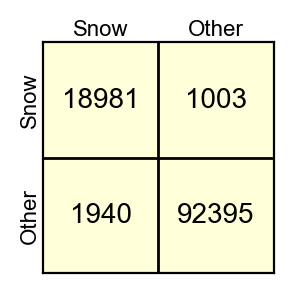

In [15]:
# figure showing confusion matrix, just snow vs everything else
fig,axs = plt.subplots(figsize=(1.5,1.5), dpi=200)

to_show = [ [avg_cm[0][0],              np.nansum(avg_cm[0,1:])],
            [np.nansum(avg_cm[1:,0]),  np.nansum(avg_cm[1:,1:])] ]

im = axs.imshow(to_show, vmin=1000000, vmax=1000001, cmap="YlGnBu",)

labels = ['Snow', 'Other']

axs.set_xticks([0,1])
axs.set_xticklabels(labels, ha='center', size=8)
axs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, rotation=0, pad=1, length=0)

axs.set_yticks([0,1])
axs.set_yticklabels(labels, va='center', size=8, rotation=90)

# axs.set_ylabel("Truth", labelpad=0)
# axs.set_xlabel("Predicted", labelpad=0)
# axs.xaxis.set_label_position('top') 

# add label for accuracy of each class
for r in [0,1]:
    for c in [0,1]:
        n = round(to_show[r][c])
        axs.text(c,r,n, horizontalalignment='center', verticalalignment='center',)

axs.hlines([0.5,1.5],-0.5,1.5, color='black', linewidth=1)
axs.vlines([0.5,1.5],-0.5,1.5, color='black', linewidth=1)

# print accuracy and f1
a = (to_show[0][0]+to_show[1][1])/np.nansum(to_show)
p = to_show[0][0]/(to_show[0][0]+to_show[1][0])
r = to_show[0][0]/(to_show[0][0]+to_show[0][1])
f1 = 2*(p*r)/(p+r)
print("Accuracy:", round(a,3))
print("Precision:", round(p,3))
print("Recall:", round(r,3))
print("F1_score:", round(f1,3))
# 2 * TPR * PPV / (TPR + PPV)

# fig.colorbar(im, shrink=0.7, label='Count')

out_path = os.path.join(folder_AGVA, 'Figures', 'training accuracy', 'snow.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [ ]:
# figure showing confusion matrix, just snow vs everything else
fig,axs = plt.subplots(figsize=(3.5,4), dpi=200)

to_show = [ [avg_cm[0][0],               avg_cm[0,1],                   np.nansum(avg_cm[0,2:])],
            [avg_cm[1][0],               avg_cm[1,1],                   np.nansum(avg_cm[1,2:])],
            [np.nansum(avg_cm[2:,0]),    np.nansum(avg_cm[2:,1]),       np.nansum(avg_cm[2:,2:])],]
            
#            [np.nansum(avg_cm[1:,0]),  np.nansum(avg_cm[1:,1:])] ]

im = axs.imshow(to_show, vmin=0, vmax=100000, cmap="YlGnBu")

labels = ['Snow', 'Firn', 'Other']

axs.set_xticks([0,1,2])
axs.set_xticklabels(labels)
axs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, rotation=45, pad=0, length=0)

axs.set_yticks([0,1,2])
axs.set_yticklabels(labels)

# axs.set_ylabel("Truth", labelpad=0)
# axs.set_xlabel("Predicted", labelpad=0)
# axs.xaxis.set_label_position('top') 

# add label for accuracy of each class
for r in [0,1,2]:
    for c in [0,1,2]:
        n = round(to_show[r][c])
        axs.text(c,r,n, horizontalalignment='center', verticalalignment='center',)

axs.hlines([0.5,1.5],-0.5,2.5, color='black', linewidth=1)
axs.vlines([0.5,1.5],-0.5,2.5, color='black', linewidth=1)

fig.colorbar(im, shrink=0.7, label='Count')

# ConfusionMatrixDisplay(confusion_matrix=).plot()

In [ ]:
### figure of average predictor importance
importances_df_plot = importances_df.mean(axis=1)
mini = importances_df.min(axis=1).values
maxi = importances_df.max(axis=1).values

fig, ax = plt.subplots(figsize=(9,5), dpi=100)
ax.bar(range(len(importances_df_plot)),height=importances_df_plot, zorder=10, yerr=[mini,maxi])

plt.grid(axis='y', zorder=1)
ax.set_xticks(range(len(importances_df_plot)))
ax.set_xticklabels(importances_df_plot.index, rotation=90, ha='center')

plt.ylabel('Importance')
#     plt.title(f'Test Image: {test_image}')
plt.tight_layout()

In [ ]:
# print the average accuracy etc
print("Accuracy")
print("Mean:", np.nanmean(results_df['Accuracy']) )
print("Median:", np.nanmedian(results_df['Accuracy']) )
print("Min:", np.nanmax(results_df['Accuracy']) )
print("Max:", np.nanmin(results_df['Accuracy']) )
print()

print("F1")
print("Mean:", np.nanmean(results_df['F1']) )
print("Median:", np.nanmedian(results_df['F1']) )
print("Max:", np.nanmax(results_df['F1']) )
print("Min:", np.nanmin(results_df['F1']) )
print()

In [ ]:
# accuracy etc for just snow
a_s = []
f_s = []
for c in cms:
    to_show = [ [c[0][0],              np.nansum(c[0,1:])],
                [np.nansum(c[1:,0]),  np.nansum(c[1:,1:])] ]

    # print accuracy and f1
    a = (to_show[0][0]+to_show[1][1])/np.nansum(to_show)
    p = to_show[0][0]/(to_show[0][0]+to_show[1][0])
    r = to_show[0][0]/(to_show[0][0]+to_show[0][1])
    f1 = 2*(p*r)/(p+r)
    a_s.append(a)
    f_s.append(f1)
#     print("Accuracy:", round(a,3))
# #     print("Precision:", round(p,3))
# #     print("Recall:", round(r,3))
#     print("F1_score:", round(f1,3))

print("Accuracy")
print("Mean:", np.nanmean(a_s) )
print("Median:", np.nanmedian(a_s) )
print("Min:", np.nanmax(a_s) )
print("Max:", np.nanmin(a_s) )
print()

print("F1")
print("Mean:", np.nanmean(f_s) )
print("Median:", np.nanmedian(f_s) )
print("Max:", np.nanmax(f_s) )
print("Min:", np.nanmin(f_s) )
print()

In [ ]:
2 * TPR * PPV / (TPR + PPV)